In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy import stats

In [2]:
import random
random.seed(13)

### Import data

In [3]:
# maybe use np.where to reduce the data imported

Read

In [4]:
# code = pd.read_csv('data/coding7128.tsv', sep='\t')

In [5]:
# need to import this file in slightly different way because of different delimiters
clinical = pd.read_csv('data/covid19_clinical_sample.txt',sep='\t|,', engine = 'python')

In [6]:
clinical_old = pd.read_csv('data/tpp_gp_clinical_subset.csv')

In [7]:
ic10 = pd.read_csv('data/ic10_lookup.csv')

In [8]:
GPic10 = pd.read_csv('data/GP_ic10_lookup.csv') 

In [9]:
# need to import this file in slightly different way because of different delimiters
scripts = pd.read_csv('data/covid19_prescriptions_sample.txt', sep='\t|,', engine = 'python')

In [10]:
scripts_old = pd.read_csv('data/sample_covid19_tpp_gp_scripts.txt')

In [11]:
mortality = pd.read_csv('data/patients_data_death_sample.csv')

In [12]:
mortality_coding = pd.read_csv('data/patients_data_death_decoding.csv')

have a look at the data

In [13]:
# code.head()
# CTV3 codes (used by GPs, in dataset clinical) and the corresponding disease and incidences
# code can also be measurements, but will not be used by us

In [14]:
clinical
# GP dataset from every patient
# each line corresponds to one incident with a date (event_dt)
# eid: patient number 
# code_type: ?
# value: measured value of a test or whatever

,Unnamed: 0,eid,event_dt,code_type,code,value
0,0,1000034,25/07/2017,0,XaIyt,0.000000
1,1,1000034,26/06/2018,0,XaF8d,0.000000
2,2,1000034,22/08/2017,0,XaF8d,0.000000
3,3,1000034,04/08/2015,0,XaF8d,0.000000
4,4,1000034,07/06/2018,0,XaIeG,0.000000
...,...,...,...,...,...,...
999995,999995,1033328,23/05/2012,0,42N..,0.330000
999996,999996,1033328,10/07/2013,0,246A.,80.000000
999997,999997,1033328,23/05/2012,0,XaK8y,83.300003
999998,999998,1033328,20/05/1997,0,246A.,80.000000


In [15]:
clinical_old

,Unnamed: 0,eid,event_dt,code_type,code,value
0,101084316,4392480,31/12/2020,0,XaERu,11.00
1,9359934,1311969,31/12/2020,0,XaN3z,0.80
2,9360007,1311969,31/12/2020,0,44P6.,0.58
3,111269383,4731119,31/12/2020,0,XaIm8,0.00
4,9360002,1311969,31/12/2020,0,44P5.,1.30
...,...,...,...,...,...,...
49995,46497795,2564395,31/12/2019,0,XaFqt,0.00
49996,46497794,2564395,31/12/2019,0,XaIVg,0.00
49997,41639202,2400982,31/12/2019,0,XaEJK,0.00
49998,116371391,4900832,31/12/2019,0,X1004,0.00


In [16]:
ic10
# description of ICD20 codes

,Unnamed: 0,ICD10_CODE,ALT_CODE,USAGE,USAGE_UK,DESCRIPTION,MODIFIER_4,MODIFIER_5,QUALIFIERS,GENDER_MASK,MIN_AGE,MAX_AGE,TREE_DESCRIPTION
0,0,A00,A00,DEFAULT,3.0,Cholera,,,,,,,
1,1,A00.0,A000,DEFAULT,3.0,"Cholera due to Vibrio cholerae 01, biovar chol...",,,,,,,
2,2,A00.1,A001,DEFAULT,3.0,"Cholera due to Vibrio cholerae 01, biovar eltor",,,,,,,
3,3,A00.9,A009,DEFAULT,3.0,"Cholera, unspecified",,,,,,,
4,4,A01,A01,DEFAULT,3.0,Typhoid and paratyphoid fevers,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17931,17931,U84.8,U848,DEFAULT,3.0,Resistance to other specified antimicrobial drug,,,,,,,
17932,17932,U84.9,U849,DEFAULT,3.0,Resistance to unspecified antimicrobial drugs,,,,,,,
17933,17933,U85,U85X,DEFAULT,3.0,Resistance to antineoplastic drugs,,,,,,,
17934,17934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
GPic10
#translates CTV3 codes (read_code) to ICD10 (icd10_code)

,Unnamed: 0,read_code,icd10_code,mapping_status,refine_flag,add_code_flag,element_num,block_num
0,0,123..,Z831,D,C,M,0.0,0.0
1,1,123..,Z830,A,C,M,0.0,0.0
2,2,1231.,Z831,G,C,M,0.0,0.0
3,3,1232.,Z831,G,C,M,0.0,0.0
4,4,1233.,Z831,G,C,M,0.0,0.0
...,...,...,...,...,...,...,...,...
116372,116372,ZVy..,Z769,D,C,C,0.0,0.0
116373,116373,ZVz..,Z769,D,C,C,0.0,0.0
116374,116374,NaN,NaN,NaN,NaN,NaN,NaN,NaN
116375,116375,"Contains information from NHS Digital, licence...",NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
scripts
# all medication patients got from their GP, incl. the COVID-19 vaccine 
# needs to be complete if want to compare vaccinated vs. non-vaccinated, but seems like not all vaccinations registered here but just the ones done by the GP

,Unnamed: 0,eid,issue_date,dmd_code
0,0,1000034,05/08/2016,317310006
1,1,1000034,16/03/2015,317310006
2,2,1000034,22/05/2017,317310006
3,3,1000034,31/03/2016,317310006
4,4,1000034,23/01/2019,317310006
...,...,...,...,...
999995,999995,1069267,22/06/2015,347928005
999996,999996,1069267,26/07/1997,382311000001103
999997,999997,1069267,13/03/1997,374296008
999998,999998,1069267,15/07/1997,382311000001103


In [19]:
scripts_old

,Unnamed: 0,eid,issue_date,dmd_code
0,39278003,3743492,2021-03-22,320031002
1,35914327,3508920,2021-03-15,3591211000001105
2,49790799,4472075,2021-05-03,33405511000001102
3,31447155,3192040,2021-03-15,321745007
4,69964306,5879124,2021-01-19,320031002
...,...,...,...,...
99995,62996879,5393814,2021-01-27,320030001
99996,47834233,4333940,2021-01-03,38893411000001105
99997,33831040,3365447,2021-03-31,318052005
99998,12832421,1889162,2021-03-30,321152004


In [20]:
# get few individuals from large dataset -> may try to call only part of scripts dataset, where code == one of covid vaccine

# try only to get lines from scripts dataset where dmd_code== a vaccine 
# use function read_csv. only where irgendwas

print('lines in samplescripts: ', len(scripts))
print('number of subjects in samplescripts: ', len(scripts['eid'].value_counts()))

lines in samplescripts:  1000000
number of subjects in samplescripts:  2589


### Preparing the data

#### Adding column with IC10 categories to clinical dataset for simpler analysis later on

In [21]:
# create a reduced dataset for merging with the clinical dataset 
GPic10_red =  GPic10[['read_code', 'icd10_code']]
# rename to merge ont he ctv3 column with the clinical dataset
GPic10_red = GPic10_red.rename(columns = {'read_code':'code'})
GPic10_red.head()

,code,icd10_code
0,123..,Z831
1,123..,Z830
2,1231.,Z831
3,1232.,Z831
4,1233.,Z831


In [22]:
clinical_ic10 = pd.merge(clinical, GPic10_red, how='inner', on='code')
clinical_ic10

,Unnamed: 0,eid,event_dt,code_type,code,value,icd10_code
0,42,1000034,13/05/1998,0,XE1lT,0.0,S832
1,326324,1011402,15/08/2003,0,XE1lT,0.0,S832
2,326338,1011402,11/03/2004,0,XE1lT,0.0,S832
3,326339,1011402,16/07/2004,0,XE1lT,0.0,S832
4,371890,1012829,06/01/2015,0,XE1lT,0.0,S832
...,...,...,...,...,...,...,...
188488,996399,1033266,23/06/2015,0,XaDbE,0.0,R568
188489,999941,1033328,11/12/2018,0,X2060,0.0,I839
188490,999941,1033328,11/12/2018,0,X2060,0.0,I83
188491,999941,1033328,11/12/2018,0,X2060,0.0,O220


#### Data Cleaning

In [23]:
# drop unnecessary columns
clinical_ic10.drop(columns = ['code_type', 'value', 'Unnamed: 0'], inplace = True)
clinical_ic10

,eid,event_dt,code,icd10_code
0,1000034,13/05/1998,XE1lT,S832
1,1011402,15/08/2003,XE1lT,S832
2,1011402,11/03/2004,XE1lT,S832
3,1011402,16/07/2004,XE1lT,S832
4,1012829,06/01/2015,XE1lT,S832
...,...,...,...,...
188488,1033266,23/06/2015,XaDbE,R568
188489,1033328,11/12/2018,X2060,I839
188490,1033328,11/12/2018,X2060,I83
188491,1033328,11/12/2018,X2060,O220


In [24]:
pd.isnull(clinical_ic10).sum()
# no NaN

eid           0
event_dt      0
code          0
icd10_code    0
dtype: int64

In [25]:
pd.isnull(ic10).sum()

Unnamed: 0          0
ICD10_CODE          1
ALT_CODE            2
USAGE               2
USAGE_UK            2
DESCRIPTION         2
MODIFIER_4          2
MODIFIER_5          2
QUALIFIERS          2
GENDER_MASK         2
MIN_AGE             2
MAX_AGE             2
TREE_DESCRIPTION    2
dtype: int64

In [26]:
# remove duplicate entries in clinical dataset 
# (for other datasets, it should not be a problem)
clinical_ic10.drop_duplicates(inplace = True) 

# remove NaN in selected column
ic10.dropna(subset=['DESCRIPTION'], inplace = True)

In [27]:
pd.isnull(ic10).sum()

Unnamed: 0          0
ICD10_CODE          0
ALT_CODE            0
USAGE               0
USAGE_UK            0
DESCRIPTION         0
MODIFIER_4          0
MODIFIER_5          0
QUALIFIERS          0
GENDER_MASK         0
MIN_AGE             0
MAX_AGE             0
TREE_DESCRIPTION    0
dtype: int64

In [28]:
clinical_ic10

,eid,event_dt,code,icd10_code
0,1000034,13/05/1998,XE1lT,S832
1,1011402,15/08/2003,XE1lT,S832
2,1011402,11/03/2004,XE1lT,S832
3,1011402,16/07/2004,XE1lT,S832
4,1012829,06/01/2015,XE1lT,S832
...,...,...,...,...
188488,1033266,23/06/2015,XaDbE,R568
188489,1033328,11/12/2018,X2060,I839
188490,1033328,11/12/2018,X2060,I83
188491,1033328,11/12/2018,X2060,O220


In [29]:
type(('O','P','S','T','U','V','W','X','Y','Z'))

tuple

In [30]:
# remove not considered clinical events in the clinical dataset (e.g. external factors)

""""
Monica's suggestions: 
remove O-Z (pregnancy, congenital, others, COVID-19, external causes, factors)
maybe keep Q (congenital) as underlying disease, keep all others

Renée:
I would also keep R in there: "In general, categories in this chapter include the less well-defined conditions and symptoms that, without the necessary study of the case to establish a final diagnosis, point perhaps equally to two or more diseases or to two or more systems of the body.

Decision:
O-Z remove, but leave R as adverse event & Q as underlying disease.

"""

# tuple of categories we do not consider as adverse event or underlying disease:
# the ones starting with O-Z (except Q and R)
exclude = ('O','P','S','T','U','V','W','X','Y','Z')

# broadcasting the clinical dataset for all icd codes except those we exclude
clinical_ic10 = clinical_ic10[~clinical_ic10['icd10_code'].astype(str).str.startswith(exclude)]
clinical_ic10

,eid,event_dt,code,icd10_code
12,1000034,01/01/1978,XE0e7,N419
13,1000034,01/01/1978,XE0e7,N41
14,1013867,10/01/2003,XE0e7,N419
15,1013867,10/01/2003,XE0e7,N41
16,1000034,23/01/2019,XE1FC,M543
...,...,...,...,...
188460,1033266,11/02/2016,XaQv0,R452
188461,1033266,25/02/2015,X75Z0,R568
188488,1033266,23/06/2015,XaDbE,R568
188489,1033328,11/12/2018,X2060,I839


#### Rename columns of mortality dataframe

In [31]:
scripts_old

,Unnamed: 0,eid,issue_date,dmd_code
0,39278003,3743492,2021-03-22,320031002
1,35914327,3508920,2021-03-15,3591211000001105
2,49790799,4472075,2021-05-03,33405511000001102
3,31447155,3192040,2021-03-15,321745007
4,69964306,5879124,2021-01-19,320031002
...,...,...,...,...
99995,62996879,5393814,2021-01-27,320030001
99996,47834233,4333940,2021-01-03,38893411000001105
99997,33831040,3365447,2021-03-31,318052005
99998,12832421,1889162,2021-03-30,321152004


In [32]:
# get few individuals from large dataset -> may try to call only part of scripts dataset, where code == one of covid vaccine

# try only to get lines from scripts dataset where dmd_code== a vaccine 
# use function read_csv. only where irgendwas

print('lines in samplescripts: ', len(scripts))
print('number of subjects in samplescripts: ', len(scripts['eid'].value_counts()))

lines in samplescripts:  1000000
number of subjects in samplescripts:  2589


### Preparing the data

#### Adding column with IC10 categories to clinical dataset for simpler analysis later on

In [33]:
# create a reduced dataset for merging with the clinical dataset 
GPic10_red =  GPic10[['read_code', 'icd10_code']]
# rename to merge ont he ctv3 column with the clinical dataset
GPic10_red = GPic10_red.rename(columns = {'read_code':'code'})
GPic10_red.head()

,code,icd10_code
0,123..,Z831
1,123..,Z830
2,1231.,Z831
3,1232.,Z831
4,1233.,Z831


In [34]:
clinical_ic10 = pd.merge(clinical, GPic10_red, how='inner', on='code')
clinical_ic10

,Unnamed: 0,eid,event_dt,code_type,code,value,icd10_code
0,42,1000034,13/05/1998,0,XE1lT,0.0,S832
1,326324,1011402,15/08/2003,0,XE1lT,0.0,S832
2,326338,1011402,11/03/2004,0,XE1lT,0.0,S832
3,326339,1011402,16/07/2004,0,XE1lT,0.0,S832
4,371890,1012829,06/01/2015,0,XE1lT,0.0,S832
...,...,...,...,...,...,...,...
188488,996399,1033266,23/06/2015,0,XaDbE,0.0,R568
188489,999941,1033328,11/12/2018,0,X2060,0.0,I839
188490,999941,1033328,11/12/2018,0,X2060,0.0,I83
188491,999941,1033328,11/12/2018,0,X2060,0.0,O220


#### Data Cleaning

In [35]:
# drop unnecessary columns
clinical_ic10.drop(columns = ['code_type', 'value', 'Unnamed: 0'], inplace = True)
clinical_ic10

,eid,event_dt,code,icd10_code
0,1000034,13/05/1998,XE1lT,S832
1,1011402,15/08/2003,XE1lT,S832
2,1011402,11/03/2004,XE1lT,S832
3,1011402,16/07/2004,XE1lT,S832
4,1012829,06/01/2015,XE1lT,S832
...,...,...,...,...
188488,1033266,23/06/2015,XaDbE,R568
188489,1033328,11/12/2018,X2060,I839
188490,1033328,11/12/2018,X2060,I83
188491,1033328,11/12/2018,X2060,O220


In [36]:
pd.isnull(clinical_ic10).sum()
# no NaN

eid           0
event_dt      0
code          0
icd10_code    0
dtype: int64

In [37]:
pd.isnull(ic10).sum()

Unnamed: 0          0
ICD10_CODE          0
ALT_CODE            0
USAGE               0
USAGE_UK            0
DESCRIPTION         0
MODIFIER_4          0
MODIFIER_5          0
QUALIFIERS          0
GENDER_MASK         0
MIN_AGE             0
MAX_AGE             0
TREE_DESCRIPTION    0
dtype: int64

In [38]:
# remove duplicate entries in clinical dataset 
# (for other datasets, it should not be a problem)
clinical_ic10.drop_duplicates(inplace = True) 

# remove NaN in selected column
ic10.dropna(subset=['DESCRIPTION'], inplace = True)

In [39]:
pd.isnull(ic10).sum()

Unnamed: 0          0
ICD10_CODE          0
ALT_CODE            0
USAGE               0
USAGE_UK            0
DESCRIPTION         0
MODIFIER_4          0
MODIFIER_5          0
QUALIFIERS          0
GENDER_MASK         0
MIN_AGE             0
MAX_AGE             0
TREE_DESCRIPTION    0
dtype: int64

In [40]:
clinical_ic10

,eid,event_dt,code,icd10_code
0,1000034,13/05/1998,XE1lT,S832
1,1011402,15/08/2003,XE1lT,S832
2,1011402,11/03/2004,XE1lT,S832
3,1011402,16/07/2004,XE1lT,S832
4,1012829,06/01/2015,XE1lT,S832
...,...,...,...,...
188488,1033266,23/06/2015,XaDbE,R568
188489,1033328,11/12/2018,X2060,I839
188490,1033328,11/12/2018,X2060,I83
188491,1033328,11/12/2018,X2060,O220


In [41]:
type(('O','P','S','T','U','V','W','X','Y','Z'))

tuple

In [42]:
# remove not considered clinical events in the clinical dataset (e.g. external factors)

""""
Monica's suggestions: 
remove O-Z (pregnancy, congenital, others, COVID-19, external causes, factors)
maybe keep Q (congenital) as underlying disease, keep all others

Renée:
I would also keep R in there: "In general, categories in this chapter include the less well-defined conditions and symptoms that, without the necessary study of the case to establish a final diagnosis, point perhaps equally to two or more diseases or to two or more systems of the body.

Decision:
O-Z remove, but leave R as adverse event & Q as underlying disease.

"""

# tuple of categories we do not consider as adverse event or underlying disease:
# the ones starting with O-Z (except Q and R)
exclude = ('O','P','S','T','U','V','W','X','Y','Z')

# broadcasting the clinical dataset for all icd codes except those we exclude
clinical_ic10 = clinical_ic10[~clinical_ic10['icd10_code'].str.startswith(exclude)]
clinical_ic10

,eid,event_dt,code,icd10_code
12,1000034,01/01/1978,XE0e7,N419
13,1000034,01/01/1978,XE0e7,N41
14,1013867,10/01/2003,XE0e7,N419
15,1013867,10/01/2003,XE0e7,N41
16,1000034,23/01/2019,XE1FC,M543
...,...,...,...,...
188460,1033266,11/02/2016,XaQv0,R452
188461,1033266,25/02/2015,X75Z0,R568
188488,1033266,23/06/2015,XaDbE,R568
188489,1033328,11/12/2018,X2060,I839


#### Rename columns of mortality dataframe

In [43]:
mortality.head()

,Unnamed: 0,eid,31-0.0,34-0.0,52-0.0,53-0.0,21001-0.0,21022-0.0,40000-0.0,40001-0.0,40001-1.0,40007-0.0
0,334517,4345610,1.0,1940.0,2.0,2009-09-17,28.4091,69.0,NaN,NaN,NaN,NaN
1,297000,3970369,1.0,1949.0,12.0,2008-04-18,26.1106,58.0,NaN,NaN,NaN,NaN
2,260822,3608558,1.0,1943.0,2.0,2010-02-26,27.4614,67.0,NaN,NaN,NaN,NaN
3,245361,3453904,0.0,1957.0,8.0,2010-03-19,29.3199,52.0,NaN,NaN,NaN,NaN
4,25616,1256219,1.0,1959.0,7.0,2008-12-20,32.7859,49.0,NaN,NaN,NaN,NaN


In [44]:
mortality_coding

,Unnamed: 0,description
0,eid,PatientID
1,21022-0.0,AgeRecruit
2,53-0.0,DateRecruit
3,34-0.0,YearBirth
4,52-0.0,MonthBirth
5,40007-0.0,AgeDeath
6,40000-0.0,DateDeath
7,31-0.0,Sex
8,21001-0.0,BMI
9,40001-0.0,cause of death 1


In [45]:
# make a dictionary out of the mortality_coding dataframe 
dict_columns = {}
for index, value in enumerate(mortality_coding['Unnamed: 0']):
  dict_columns[value] = mortality_coding.loc[index, "description"]

In [46]:
mortality.rename(columns = dict_columns, inplace = True) # columns = a dictionary will automatically rename the columns
mortality['DateDeath'].isna().sum()
# mortality['DateDeath'].value_counts()


9339

In [47]:
mortality

,Unnamed: 0,PatientID,Sex,YearBirth,MonthBirth,DateRecruit,BMI,AgeRecruit,DateDeath,cause of death 1,cause of death 2,AgeDeath
0,334517,4345610,1.0,1940.0,2.0,2009-09-17,28.4091,69.0,NaN,NaN,NaN,NaN
1,297000,3970369,1.0,1949.0,12.0,2008-04-18,26.1106,58.0,NaN,NaN,NaN,NaN
2,260822,3608558,1.0,1943.0,2.0,2010-02-26,27.4614,67.0,NaN,NaN,NaN,NaN
3,245361,3453904,0.0,1957.0,8.0,2010-03-19,29.3199,52.0,NaN,NaN,NaN,NaN
4,25616,1256219,1.0,1959.0,7.0,2008-12-20,32.7859,49.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,218679,3187034,0.0,1969.0,4.0,2009-10-19,26.1005,40.0,NaN,NaN,NaN,NaN
9996,282089,3821234,0.0,1962.0,5.0,2010-03-02,28.3801,47.0,NaN,NaN,NaN,NaN
9997,219163,3191883,1.0,1964.0,1.0,2008-09-12,13.9123,44.0,NaN,NaN,NaN,NaN
9998,55963,1559739,0.0,1946.0,10.0,2008-10-08,25.4259,61.0,NaN,NaN,NaN,NaN


## Find who is vaccinated

The meaning of the SNOMED codes ('dmd_code' in the 'scripts' dataset, where medications that the patients got are listed) were found on: https://services.nhsbsa.nhs.uk/dmd-browser/amp/view/159421?ref=YW1wTmFtZT1jb3ZpZCZzZWFyY2hUeXBlPUFNUCZzaG93SW52YWxpZEl0ZW1zPWZhbHNl#ampCodes

Each vaccine has a specific code.

In [48]:
# broadcasting to find individuals with AstraZEneca vaccine
mask_AZ = scripts['dmd_code']== 39114911000001105
scripts[mask_AZ].head()

,Unnamed: 0,eid,issue_date,dmd_code
261135,261135,1018525,21/03/2021,39114911000001105
597692,597692,1040468,30/01/2021,39114911000001105
970763,970763,1066390,29/01/2021,39114911000001105
970765,970765,1066390,20/03/2021,39114911000001105


In [49]:
# getting IDs of individuals with any corona vaccine first (compare vaccinates vs. not)
# may look at effects of specific vaccines later
dict_vac = {39326911000001101: 'Moderna', 39230211000001104: 'Janssen', \
            39826711000001101:'Medicago', 39473011000001103: 'Baxter', \
            39114911000001105: 'AstraZeneca', 39115611000001103: 'Pfizer',\
            39373511000001104: 'Valneva'}

for dmd_code in dict_vac:
    mask_vac = scripts['dmd_code']== dmd_code
    print(dict_vac[dmd_code], ':',len(scripts[mask_vac]))

Moderna : 0
Janssen : 0
Medicago : 0
Baxter : 0
AstraZeneca : 4
Pfizer : 2
Valneva : 0


In [50]:
# mask for any vaccine
mask_vac = scripts['dmd_code'].isin(dict_vac)

# number of vaccinated people
print('Number of vaccinated people:', len(scripts[mask_vac]))

Number of vaccinated people: 6


In [51]:
# finding eids of vaccinated people in the dataset
id_vac = scripts[mask_vac]['eid'] 
id_vac

19471     1000899
261135    1018525
466220    1031590
597692    1040468
970763    1066390
970765    1066390
Name: eid, dtype: int64

In [52]:
# finding events of the vaccinated people, but only events before vaccination found 
# -> may need a more recent dataset
# need to separate clinical events before & after vaccine
mask_vac_clin = clinical_ic10['eid'].isin(id_vac)
clinical_ic10[mask_vac_clin] 

,eid,event_dt,code,icd10_code
2099,1000899,29/07/2013,X75rv,M255
2100,1000899,29/07/2013,X75rv,A180D
2101,1000899,29/07/2013,X75rv,M011A
2104,1000899,06/02/2020,X75rv,M255
2105,1000899,06/02/2020,X75rv,A180D
...,...,...,...,...
184032,1018525,30/03/2020,K24..,N459
184033,1018525,30/03/2020,K24..,N45
184034,1018525,22/03/2012,J323z,K429
184035,1018525,14/03/1995,H03z.,J039


# categorize event as before or after COVID-19 vaccination / random date 

### make 'event_date' in 'clinical' be interpreted as a date

In [53]:
clinical_ic10.head(10)

,eid,event_dt,code,icd10_code
12,1000034,01/01/1978,XE0e7,N419
13,1000034,01/01/1978,XE0e7,N41
14,1013867,10/01/2003,XE0e7,N419
15,1013867,10/01/2003,XE0e7,N41
16,1000034,23/01/2019,XE1FC,M543
17,1000034,23/01/2019,XE1FC,M544
18,1000034,23/01/2019,XE1FC,G570
19,1000034,23/01/2019,XE1FC,M511
20,1000034,23/01/2019,XE1FC,M511D
21,1000034,23/01/2019,XE1FC,G551A


In [54]:
from datetime import datetime, timedelta

### only to understand the function, can be deleted later

In [55]:
clinical_ic10['event_dt'].unique()
# find out if the other dates are e.g. 06/01/2020 or 6/1/2020

array(['01/01/1978', '10/01/2003', '23/01/2019', ..., '18/11/1996',
       '20/02/1957', '04/12/1956'], dtype=object)

In [56]:
example_date = clinical_ic10['event_dt'].unique()[0]

In [57]:
example_date_new = datetime.strptime(example_date, '%d/%m/%Y')
example_date_new #2020

datetime.datetime(1978, 1, 1, 0, 0)

In [58]:
example_date_2 = clinical_ic10['event_dt'].unique()[1]
example_date_2 

'10/01/2003'

In [59]:
example_date_2_new = datetime.strptime(example_date_2, '%d/%m/%Y')
example_date_2_new #2019

datetime.datetime(2003, 1, 10, 0, 0)

In [60]:
# compare the 2 dates
example_date_new > example_date_2_new # 2020 > 2019 --> True
# recent > older --> True

False

### convert the column into datetime object

In [61]:
# convert entire event_dt in datetime format
clinical_ic10['event_date_format'] = pd.to_datetime(clinical_ic10['event_dt'])
clinical_ic10

C:\Users\renee\AppData\Local\Temp/ipykernel_45952/3178288207.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clinical_ic10['event_date_format'] = pd.to_datetime(clinical_ic10['event_dt'])


,eid,event_dt,code,icd10_code,event_date_format
12,1000034,01/01/1978,XE0e7,N419,1978-01-01
13,1000034,01/01/1978,XE0e7,N41,1978-01-01
14,1013867,10/01/2003,XE0e7,N419,2003-10-01
15,1013867,10/01/2003,XE0e7,N41,2003-10-01
16,1000034,23/01/2019,XE1FC,M543,2019-01-23
...,...,...,...,...,...
188460,1033266,11/02/2016,XaQv0,R452,2016-11-02
188461,1033266,25/02/2015,X75Z0,R568,2015-02-25
188488,1033266,23/06/2015,XaDbE,R568,2015-06-23
188489,1033328,11/12/2018,X2060,I839,2018-11-12


In [62]:
# checking the date range
clinical_ic10.sort_values(by = 'event_date_format', ascending = False)

,eid,event_dt,code,icd10_code,event_date_format
173433,1014125,07/07/2037,X785s,Q613,2037-07-07
183184,1016438,12/03/2021,X2033,I272,2021-12-03
183185,1016438,12/03/2021,X2033,I270,2021-12-03
160773,1028939,12/03/2021,XE0r3,R198,2021-12-03
121248,1028594,12/03/2021,XaE5D,M858,2021-12-03
...,...,...,...,...,...
81833,1000624,01/01/1901,M12z0,L309,1901-01-01
186024,1023271,01/01/1901,XaIRZ,J303,1901-01-01
82616,1009699,01/01/1901,G2...,I10X,1901-01-01
188015,1031708,01/01/1901,A741.,B330,1901-01-01


In [63]:
# only to understand the function, can be deleted later!!
# compare 2 dates (first row and last row) from the new column 

print(clinical_ic10['event_date_format'].iloc[-1]) # 2019
print(clinical_ic10['event_date_format'].iloc[0]) # 2020
clinical_ic10['event_date_format'].iloc[0] > clinical_ic10['event_date_format'].iloc[-1]

2018-11-12 00:00:00
1978-01-01 00:00:00


False

### subset 'scripts' to only those patients (eid) that got the COVID-19 vaccine and drop 'Unnamed: 0' column

In [64]:
scripts.drop(columns = ['Unnamed: 0'], inplace = True)
mask_scripts_vac = scripts['dmd_code'].isin(dict_vac)
scripts_vaccines_only = scripts[mask_scripts_vac] 

len(scripts[mask_scripts_vac]) # corresponds to finding above

6

In [65]:
scripts_vaccines_only.head() # contains eid and date of vaccination

,eid,issue_date,dmd_code
19471,1000899,09/01/2021,39115611000001103
261135,1018525,21/03/2021,39114911000001105
466220,1031590,23/02/2021,39115611000001103
597692,1040468,30/01/2021,39114911000001105
970763,1066390,29/01/2021,39114911000001105


In [66]:
# gives warning (same as before, should maybe be checked!)
scripts_vaccines_only['issue_date_format'] = pd.to_datetime(scripts_vaccines_only['issue_date'])


C:\Users\renee\AppData\Local\Temp/ipykernel_45952/3051744947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scripts_vaccines_only['issue_date_format'] = pd.to_datetime(scripts_vaccines_only['issue_date'])


In [67]:
scripts_vaccines_only

,eid,issue_date,dmd_code,issue_date_format
19471,1000899,09/01/2021,39115611000001103,2021-09-01
261135,1018525,21/03/2021,39114911000001105,2021-03-21
466220,1031590,23/02/2021,39115611000001103,2021-02-23
597692,1040468,30/01/2021,39114911000001105,2021-01-30
970763,1066390,29/01/2021,39114911000001105,2021-01-29
970765,1066390,20/03/2021,39114911000001105,2021-03-20


In [68]:
clinical_ic10.head()
# length: 4156
#len(clinical_ic10['eid'].unique()) # some eid are in there multiple times (of course)

,eid,event_dt,code,icd10_code,event_date_format
12,1000034,01/01/1978,XE0e7,N419,1978-01-01
13,1000034,01/01/1978,XE0e7,N41,1978-01-01
14,1013867,10/01/2003,XE0e7,N419,2003-10-01
15,1013867,10/01/2003,XE0e7,N41,2003-10-01
16,1000034,23/01/2019,XE1FC,M543,2019-01-23


### adding deaths to clinical_ic10 df so they can be treated as adverse events in first analysis (?)

In [69]:
# subset mortality df to the eids with a deathdate that is not NaN
mortality_sub = mortality.dropna(subset=['DateDeath'])
# drop all the unnecessary columns (also drop age and sex, perhaps no time to analyse this), keep eid, deathdate, cause
mortality_sub.drop(columns = ['Unnamed: 0', 'Sex', 'YearBirth', 'MonthBirth', 'DateRecruit', 'BMI', 'AgeDeath'], inplace = True)
# rename column 'PatientID' to 'eid' and 'DateDeath' to 'issue_date_format'
mortality_sub.rename(columns = {'PatientID':'eid', 'DateDeath':'event_date_format'}, inplace = True)

C:\Users\renee\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\renee\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [70]:
# add column 'icd10_code' to mortality, filled with string 'death'
mortality_sub['icd10_code'] = pd.Series(["death" for x in range(len(mortality.index))])


C:\Users\renee\AppData\Local\Temp/ipykernel_45952/2821320636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortality_sub['icd10_code'] = pd.Series(["death" for x in range(len(mortality.index))])


In [71]:
# make 'DateDeath' datetime type
mortality_sub['event_date_format'] = pd.to_datetime(mortality_sub['event_date_format'])


C:\Users\renee\AppData\Local\Temp/ipykernel_45952/1819874372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mortality_sub['event_date_format'] = pd.to_datetime(mortality_sub['event_date_format'])


In [72]:
mortality_sub

,eid,AgeRecruit,event_date_format,cause of death 1,cause of death 2,icd10_code
5,2717656,68.0,2015-06-05,C259,NaN,death
16,1546385,47.0,2015-06-28,C64,NaN,death
34,3694551,68.0,2013-07-27,K720,NaN,death
35,3396715,65.0,2013-03-26,J449,NaN,death
69,2692340,68.0,2015-10-09,I251,NaN,death
...,...,...,...,...,...,...
9943,1525180,46.0,2011-09-26,C509,NaN,death
9969,3152046,60.0,2019-08-06,G409,NaN,death
9979,2244275,57.0,2017-11-16,C221,NaN,death
9985,3652978,53.0,2018-08-24,G35,NaN,death


In [73]:
# now join it to the clinical_vac
clinical_ic10= pd.concat([clinical_ic10, mortality_sub], join = 'outer')


In [74]:
clinical_ic10

,eid,event_dt,code,icd10_code,event_date_format,AgeRecruit,cause of death 1,cause of death 2
12,1000034,01/01/1978,XE0e7,N419,1978-01-01,NaN,NaN,NaN
13,1000034,01/01/1978,XE0e7,N41,1978-01-01,NaN,NaN,NaN
14,1013867,10/01/2003,XE0e7,N419,2003-10-01,NaN,NaN,NaN
15,1013867,10/01/2003,XE0e7,N41,2003-10-01,NaN,NaN,NaN
16,1000034,23/01/2019,XE1FC,M543,2019-01-23,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9943,1525180,NaN,NaN,death,2011-09-26,46.0,C509,NaN
9969,3152046,NaN,NaN,death,2019-08-06,60.0,G409,NaN
9979,2244275,NaN,NaN,death,2017-11-16,57.0,C221,NaN
9985,3652978,NaN,NaN,death,2018-08-24,53.0,G35,NaN


### add a column with the date of vaccination to clinical_ic10 and drop event_dt and issue_date

In [75]:
# merge clinical_ic10 and scripts_vaccines_only to add the issue_date (date of vaccine) to the df
clinical_vac = pd.merge(clinical_ic10, scripts_vaccines_only, how ='outer', on ='eid')

In [76]:
# convert issue date to date format
# clinical_vac['issue_date_format'] = pd.to_datetime(clinical_vac['issue_date'])
# renée: I guess it's safer, since the dtype is 'datetime64' in the new column and 'object' in the old one:
# print(clinical_vac['issue_date']) 
# print(clinical_vac['issue_date_format'])

In [77]:
# drop event_dt and issue_date
clinical_vac.drop(columns = ['event_dt', 'issue_date'], inplace = True)

In [78]:
len(clinical_vac) 
# total amounts of events: vaccinations and medical events from clinical_ic10

133690

In [79]:
clinical_vac

,eid,code,icd10_code,event_date_format,AgeRecruit,cause of death 1,cause of death 2,dmd_code,issue_date_format
0,1000034,XE0e7,N419,1978-01-01,NaN,NaN,NaN,NaN,NaT
1,1000034,XE0e7,N41,1978-01-01,NaN,NaN,NaN,NaN,NaT
2,1000034,XE1FC,M543,2019-01-23,NaN,NaN,NaN,NaN,NaT
3,1000034,XE1FC,M544,2019-01-23,NaN,NaN,NaN,NaN,NaT
4,1000034,XE1FC,G570,2019-01-23,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...
133685,3652978,NaN,death,2018-08-24,53.0,G35,NaN,NaN,NaT
133686,2197584,NaN,death,2015-07-12,55.0,G122,NaN,NaN,NaT
133687,1040468,NaN,NaN,NaT,NaN,NaN,NaN,3.911491e+16,2021-01-30
133688,1066390,NaN,NaN,NaT,NaN,NaN,NaN,3.911491e+16,2021-01-29


In [80]:
clinical_vac['issue_date_format'].isna().sum()

133422

### add column in clinical_vac that says whether a patient is vaccinated or not

In [81]:
mask_vaccinated = clinical_vac['eid'].isin(id_vac)
clinical_vac['vaccinated'] = mask_vaccinated

# check how many events of vaccinated people there are
clinical_vac['vaccinated'].value_counts()

# clinical_ic10['eid'].loc[clinical_ic10['vaccinated']==True]

False    133422
True        268
Name: vaccinated, dtype: int64

In [82]:
clinical_vac 
# 133029 events
# rows with event_dt=NaN: vaccinated eids without medical events -> maybe rename it

,eid,code,icd10_code,event_date_format,AgeRecruit,cause of death 1,cause of death 2,dmd_code,issue_date_format,vaccinated
0,1000034,XE0e7,N419,1978-01-01,NaN,NaN,NaN,NaN,NaT,False
1,1000034,XE0e7,N41,1978-01-01,NaN,NaN,NaN,NaN,NaT,False
2,1000034,XE1FC,M543,2019-01-23,NaN,NaN,NaN,NaN,NaT,False
3,1000034,XE1FC,M544,2019-01-23,NaN,NaN,NaN,NaN,NaT,False
4,1000034,XE1FC,G570,2019-01-23,NaN,NaN,NaN,NaN,NaT,False
...,...,...,...,...,...,...,...,...,...,...
133685,3652978,NaN,death,2018-08-24,53.0,G35,NaN,NaN,NaT,False
133686,2197584,NaN,death,2015-07-12,55.0,G122,NaN,NaN,NaT,False
133687,1040468,NaN,NaN,NaT,NaN,NaN,NaN,3.911491e+16,2021-01-30,True
133688,1066390,NaN,NaN,NaT,NaN,NaN,NaN,3.911491e+16,2021-01-29,True


### add random issue date to events of unvaccinated patients to 'issue_date_format'  in clinical_vac 

In [83]:
# make list from 'issue_date' in scripts_vaccines_only
issue_dates = scripts_vaccines_only['issue_date_format'].tolist()
issue_dates

[Timestamp('2021-09-01 00:00:00'),
 Timestamp('2021-03-21 00:00:00'),
 Timestamp('2021-02-23 00:00:00'),
 Timestamp('2021-01-30 00:00:00'),
 Timestamp('2021-01-29 00:00:00'),
 Timestamp('2021-03-20 00:00:00')]

In [84]:
# 'eid' of unvaccinated people
id_nvac = clinical_vac[clinical_vac['vaccinated']==False]['eid'].unique()
len(id_nvac)

1895

In [85]:
# create list of new dates
issue_dt_random = random.choices(issue_dates, k = len(id_nvac))
len(issue_dt_random)

1895

In [86]:
# make dictionary with random issue dates and unvaccinated eid
dict_nvac = dict(zip(id_nvac,issue_dt_random))
len(dict_nvac)

1895

In [87]:
# fill na with mapping from the dictionary
clinical_vac['issue_date_format'] = clinical_vac['issue_date_format'].fillna(clinical_vac['eid'].map(dict_nvac))

In [88]:
clinical_vac['issue_date_format'][clinical_vac['vaccinated']==True].unique()

array(['2021-09-01T00:00:00.000000000', '2021-03-21T00:00:00.000000000',
       '2021-02-23T00:00:00.000000000', '2021-01-30T00:00:00.000000000',
       '2021-01-29T00:00:00.000000000', '2021-03-20T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [89]:
clinical_vac['issue_date_format'][clinical_vac['vaccinated']==False].unique()

array(['2021-03-21T00:00:00.000000000', '2021-01-29T00:00:00.000000000',
       '2021-03-20T00:00:00.000000000', '2021-09-01T00:00:00.000000000',
       '2021-01-30T00:00:00.000000000', '2021-02-23T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [90]:
clinical_vac[clinical_vac['vaccinated'] == False]

,eid,code,icd10_code,event_date_format,AgeRecruit,cause of death 1,cause of death 2,dmd_code,issue_date_format,vaccinated
0,1000034,XE0e7,N419,1978-01-01,NaN,NaN,NaN,NaN,2021-03-21,False
1,1000034,XE0e7,N41,1978-01-01,NaN,NaN,NaN,NaN,2021-03-21,False
2,1000034,XE1FC,M543,2019-01-23,NaN,NaN,NaN,NaN,2021-03-21,False
3,1000034,XE1FC,M544,2019-01-23,NaN,NaN,NaN,NaN,2021-03-21,False
4,1000034,XE1FC,G570,2019-01-23,NaN,NaN,NaN,NaN,2021-03-21,False
...,...,...,...,...,...,...,...,...,...,...
133682,1525180,NaN,death,2011-09-26,46.0,C509,NaN,NaN,2021-03-21,False
133683,3152046,NaN,death,2019-08-06,60.0,G409,NaN,NaN,2021-03-21,False
133684,2244275,NaN,death,2017-11-16,57.0,C221,NaN,NaN,2021-01-30,False
133685,3652978,NaN,death,2018-08-24,53.0,G35,NaN,NaN,2021-03-20,False


In [91]:
clinical_vac['issue_date_format'].isna().sum()

0

### add a column where it says if the event (event_date_format) was before or after the vaccination (issue_date)

In [92]:
before_after_vaccine = []
for i in range (len(clinical_vac)):
    if clinical_vac['event_date_format'].iloc[i] >= clinical_vac['issue_date_format'].iloc[i]:
        before_after_vaccine.append('after')
    else:
        before_after_vaccine.append('before')
clinical_vac['before_after_vaccine'] = before_after_vaccine

In [93]:
clinical_vac

,eid,code,icd10_code,event_date_format,AgeRecruit,cause of death 1,cause of death 2,dmd_code,issue_date_format,vaccinated,before_after_vaccine
0,1000034,XE0e7,N419,1978-01-01,NaN,NaN,NaN,NaN,2021-03-21,False,before
1,1000034,XE0e7,N41,1978-01-01,NaN,NaN,NaN,NaN,2021-03-21,False,before
2,1000034,XE1FC,M543,2019-01-23,NaN,NaN,NaN,NaN,2021-03-21,False,before
3,1000034,XE1FC,M544,2019-01-23,NaN,NaN,NaN,NaN,2021-03-21,False,before
4,1000034,XE1FC,G570,2019-01-23,NaN,NaN,NaN,NaN,2021-03-21,False,before
...,...,...,...,...,...,...,...,...,...,...,...
133685,3652978,NaN,death,2018-08-24,53.0,G35,NaN,NaN,2021-03-20,False,before
133686,2197584,NaN,death,2015-07-12,55.0,G122,NaN,NaN,2021-09-01,False,before
133687,1040468,NaN,NaN,NaT,NaN,NaN,NaN,3.911491e+16,2021-01-30,True,before
133688,1066390,NaN,NaN,NaT,NaN,NaN,NaN,3.911491e+16,2021-01-29,True,before


In [94]:
# checking how many events before and after
clinical_vac['before_after_vaccine'].value_counts()

# if event_date_format is NaT, is says before in 'before_after_vaccine'

before    133146
after        544
Name: before_after_vaccine, dtype: int64

# Analysing clinical events

IC10 codes are structured. The following website was used for looking up the meanings of the categories (e.g. respiratory diseases):
https://www.icd10data.com/ICD10CM/Codes

In [95]:
ic10.head()

,Unnamed: 0,ICD10_CODE,ALT_CODE,USAGE,USAGE_UK,DESCRIPTION,MODIFIER_4,MODIFIER_5,QUALIFIERS,GENDER_MASK,MIN_AGE,MAX_AGE,TREE_DESCRIPTION
0,0,A00,A00,DEFAULT,3.0,Cholera,,,,,,,
1,1,A00.0,A000,DEFAULT,3.0,"Cholera due to Vibrio cholerae 01, biovar chol...",,,,,,,
2,2,A00.1,A001,DEFAULT,3.0,"Cholera due to Vibrio cholerae 01, biovar eltor",,,,,,,
3,3,A00.9,A009,DEFAULT,3.0,"Cholera, unspecified",,,,,,,
4,4,A01,A01,DEFAULT,3.0,Typhoid and paratyphoid fevers,,,,,,,


the GP_ic10 has the read code which is the CTV3. 
(However, when things get nasty, there are multiple ICD10 codes per CTV3 codes and viceversa… there is a mapping status which tells you whether the code is primary, duplicated, to revision, etc)

In [ ]:
# WILL PROBABLY NOT USE THIS

# just to see if corresponding CTV3 to IC10 works

# broadcasting for vaccinated comorbidities(CTV3) in ICD10
mask_vac_ic10 = GPic10['read_code'].isin(clinical_ic10[mask_vac_clin]['code']) 
GPic10[mask_vac_ic10]

# mask_vac: people that got any vaccine
# search for patients that got the vaccine in GPic10
# and look what clinical events they had via the read_code (e.g. XE01qn)


if time: analyse specific diseases such as myocarditis etc.

In [ ]:
clinical_ic10

In [ ]:
ic10.head(3)

In [ ]:
# mask for getting codes related to myocarditis
mask_myocarditis = ic10['DESCRIPTION'].str.contains('myocarditis', case = False)
ic10[mask_myocarditis]

In [ ]:
# getting data with myocarditis

# the alternative code 'ALT_CODE' used here, as this was used in the lookup table GPic10
myocarditis = ic10[mask_myocarditis]['ALT_CODE']

clinical_ic10[clinical_ic10['icd10_code'].isin(myocarditis)]
# nobody had myocarditis in this restricted data

In [ ]:
## ishaemic heart disease
mask_ihd = ic10['DESCRIPTION'].str.contains('ischaemic heart disease', case = False)
ischaemicHD = ic10[mask_ihd]['ALT_CODE']
clinical_ic10[clinical_ic10['icd10_code'].isin(ischaemicHD)]

several comorbidities

In [ ]:
# getting people with specific diseases

# new column for filling with selected disease
clinical_ic10['selected disease'] = np.nan 

# list of specific diseases, to be decided on
diseases_selec = ['ischaemic heart disease', 'cardiomyopathy', 'heart failure',\
                  'myocarditis'] 

for disease in diseases_selec:
    
    # broadcasting for selected disease
    mask = ic10['DESCRIPTION'].str.contains(disease, case = False) 
    # broadcasting for selected disease
    sub_disease = clinical_ic10[clinical_ic10['icd10_code'].isin(ic10[mask]['ALT_CODE'])]
    
    for i in sub_disease.index:
        # fill dataset with selected disease label
        clinical_ic10.loc[i,'selected disease'] = disease 

In [ ]:
# counting how many people in the dataset have a specific disease
clinical_ic10['selected disease'].value_counts()

# getting people w. different categories of underlying diseases

# Question 1: What is the effect on adverse events?
## 1. How common are "adverse events"? (i.e. how many percent of vaccinated people have registered medical events after the vaccine) compare vaccinated & nonvaccinated
## 2. What about people with medical history?
## 3. Are they more common in people with (specific) underlying medical conditions? i.e.: 
* plot percentage of AEs with & without underlying conditions
* plot percentages for specific underlying conditions (not considering if several conditions at once, plot for each category then), for vaccinated and non-vaccinated people
* (optional: just for vaccinated people: plot what types of AEs (in IC10 categories) are common.

## 1. How common are "adverse events"? (i.e. how many percent of vaccinated people have registered medical events after the vaccine) compare vaccinated & nonvaccinated

In [96]:
# initialize column & index names
dict_vacORnot = {'vaccinated':1, 'not vaccinated':0} #vaccination status
ls_AE = ['AE', 'no AE'] # adverse events

Get number of adverse events (defined medical events w. ICD10 code after the (artificial) vaccination date)

In [97]:
def incidence(df_event, id_vac, id_nvac):
    """
    Calculates the number of AEs per thousand individuals in a given population.
    
    Input:
    - df_event: a dataframe containing all events considered in the analysis (e.g. AEs)
    - id_vac: series containing ID's of each individual (with each individual listed once) within the given population. // only vaccinated?
    - id_nvac: same as id_vac but with all non-vaccinated individuals
    
    
    """
    
    # initialize df for putting in the values
    df_sum = pd.DataFrame(columns = ['Number of AEs', 'Number of individuals', 'Number of AEs per thousand individuals'], index = dict_vacORnot)
    
    for v in dict_vacORnot: # loop through vaccinated vs. not
        
        # put in the number of events (AEs) by subsetting the df_event into vaccinated/not vaccinated
        df_sum['Number of AEs'][v] = len(df_event[df_event['vaccinated'] == dict_vacORnot[v]])
    
        # if we have no event (happens in the subset), add 0.5 for testing the plot and analysis further below
        # -> still visible in the output that it was added
        if df_sum['Number of AEs'][v]==0:
            df_sum['Number of AEs'][v]=0.5
    
    # put number of vaccinated/not vaccinated people in the population into the summary df
    df_sum['Number of individuals']['vaccinated'] = len(id_vac) # vaccinated (row)
    df_sum['Number of individuals']['not vaccinated'] = len(id_nvac) # not vaccinated (row)
    
    # calculate AEs/individual
    df_sum['Number of AEs per thousand individuals'] = df_sum['Number of AEs']/df_sum['Number of individuals']*1000
    
    return df_sum

#### total number of adverse events (multiple per patient in some cases) vacc vs. non-vacc.

In [98]:
# Make a df with only AEs (defined medical events w. ICD10 code after the (artificial) vaccination date)
# reminder: leave R as adverse event & Q as underlying disease.

# subset of clinical dataset for adverse events (=after vaccine)
df_AEs = clinical_vac[clinical_vac['before_after_vaccine']== 'after']

# remove Q (congenital diseases), which are not considered as adverse events
df_AEs = df_AEs[~df_AEs['icd10_code'].str.startswith('Q')]

In [112]:
# remove deaths, which are not considered as adverse events
df_AEs = df_AEs[df_AEs['icd10_code'] != 'death'] 

In [114]:
# get number of people of the chosen population
# list of all IDs from the clinical dataset
id_clin = clinical['eid'].unique()

# list of all IDs from the scripts dataset
id_scr = scripts['eid'].unique()

# concatenate both lists to get all IDs in one list
id_all = np.concatenate((id_clin, id_scr))

# leave only unique IDs in the list to get the number of IDs using len()
id_all = np.unique(id_all)

# get array with IDs without vaccine by deleting the IDs with vaccine out of the array with all IDs
id_nvac = np.delete(id_all, np.isin(id_all,id_vac))

In [115]:
# use the function to create the summary table
df_sum_all = incidence(df_AEs, id_vac, id_nvac)
df_sum_all

,Number of AEs,Number of individuals,Number of AEs per thousand individuals
vaccinated,0.5,6,83.333333
not vaccinated,537,2617,205.19679


Plot how oftern AEs occur in vaccinated vs. not vaccinated people for all individuals in the dataset.

Text(0.5, 1.0, 'Adverse events in the whole population of the dataset')

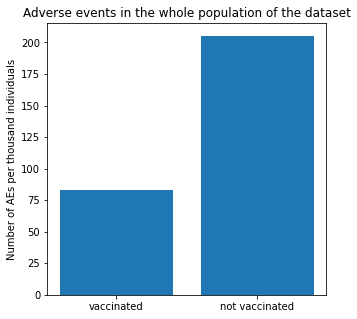

In [116]:
plt.figure(figsize = (5,5))
plt.bar(df_sum_all.index, df_sum_all['Number of AEs per thousand individuals'])
plt.ylabel('Number of AEs per thousand individuals')
plt.title('Adverse events in the whole population of the dataset')

#### contigency table and further analysis: number of eids with AE (not total AEs)

Make contingency table (not using pd.crosstab to avoid another huge dataset with all individuals and because we need to count unique IDs)

In [117]:
def contingency(df_event, id_vac, id_nvac, columns = ls_AE, index = dict_vacORnot):
    """
    Makes a 2x2 contingency table, which can be used for the chi^2 test and calculating the risk ratio.
    
    Input:
    - df_event: a dataframe containing all events considered in the analysis (e.g. AEs)
    - id_vac: series containing ID's of each individual (with each individual listed once) within the given population.
    - id_nvac: same as id_vac but with all non-vaccinated individuals
    
    """

    # initialize contingency table
    crosstab = pd.DataFrame(columns = columns, index = index)
    
    # fill contingency table with values in the subset

    for v in dict_vacORnot: # loop throug vaccinated vs. not

        
        # with AEs

        # number of nonvaccinated/vaccinated people with AEs = number of individuals with AEs
        crosstab.loc[v,'AE'] = len(df_event[df_event['vaccinated']==dict_vacORnot[v]]['eid'].unique())
        
        # DELETE THIS FOR FINAL ANALYSIS
        # if we have no event (happens in the subset), add 1 for testing the plot and analysis further below
        # -> still visible in the output that it was added
        if crosstab.loc[v,'AE']==0:
            crosstab.loc[v,'AE']=1

            
        # without AEs

        if v == 'vaccinated': # for vaccinated people

            # total number of vaccinated individuals - those with AEs
            crosstab.loc[v,'no AE'] = len(id_vac) - crosstab.loc[v,'AE']

        else: # for not vaccinated people
            
            # using id_vac
            crosstab.loc[v,'no AE'] = len(id_nvac) - crosstab.loc[v,'AE']
            
    
    # adding margins to the contingency table (=total value as row and column)
    
    # vaccinated vs. not
    crosstab.loc['Total',:] = np.sum(crosstab, axis = 0)
    # event vs. no event
    crosstab.loc[:,'Total'] = np.sum(crosstab, axis = 1)

    return crosstab
    

In [118]:
crosstab_all = contingency(df_AEs, id_vac, id_nvac)
crosstab_all

,AE,no AE,Total
vaccinated,1,5,6.0
not vaccinated,142,2475,2617.0
Total,143,2480,2623.0


Chi-squared test

In [143]:
# define significance treshold
alpha = 0.05

# perform chi-squared test:
stat, p, dof, expected = sp.stats.chi2_contingency(crosstab_all.iloc[0:2,0:2], 1)

p

0.7556129005985257

Calculate risk ratio (similar to Barda et al.)

In [119]:
def riskratio(crosstab, z = 1.96):
    """
    Calculates the risk ratio by adding a row and a column with the total count to the contingency table.
    
    Returns the risk ratio with the confidence interval (CI) as a df and the adjusted contingency table:
    (RR, crosstab)
    
    Important: the input (crosstab) needs to have the following format:
    - 2x2
    - column 0 = events (e.g. AEs), column 1 = non-events
    - row 0 = intervention (e.g. vaccinated), column 1 = non-vaccinated
    """
    
    # calculating the risk ratio

    # risk of getting AE when vaccinated
    R_vac = crosstab.loc['vaccinated','AE']/crosstab.loc['vaccinated','Total']
    # risk of getting "AE" when not vaccinated
    R_nvac = crosstab.loc['not vaccinated', 'AE']/crosstab.loc['not vaccinated', 'Total']

    # risk ratio
    RR = R_vac / R_nvac
    
    # natural log of the RR     
    logRR = np.log(RR) 

    # standard error
    se = np.sqrt(crosstab.loc['vaccinated','no AE']/ \
                 (crosstab.loc['vaccinated','AE']*crosstab.loc['vaccinated','Total']) + \
                crosstab.loc['not vaccinated','no AE']/ \
                (crosstab.loc['not vaccinated','AE']*crosstab.loc['not vaccinated','Total']))

    # Assuming normal distribution, 95% lie around 1.96 standard deviations of the mean.
    # as 95% CI is common, the z-score (z) 1.96 is put as the default value.

    # 1-alpha confidence interval (CI) 
    CI_lower = np.exp(np.log(RR) - se * z) # lower bound
    CI_upper = np.exp(np.log(RR) + se * z) # upper bound    
    
    # put the result in a series
    RR_result = pd.Series(data = [RR, CI_lower, CI_upper], index = ['RR', 'CI_lower', 'CI_upper'])
    
    return RR_result

note: se and CI calculated as described on https://en.wikipedia.org/wiki/Relative_risk. 

In [120]:
RR_all = riskratio(crosstab_all)
RR_all

RR           3.071596
CI_lower     0.509582
CI_upper    18.514608
dtype: float64

plot the RR & CI

([], [])

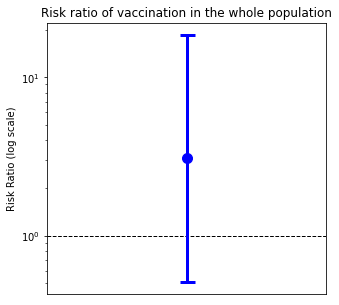

In [121]:
plt.figure(figsize = (5,5))
plt.yscale("log")
plt.axhline(1, ls='--', linewidth=1, color='black')
    
# draw the CI
x = [0,0] # x location at 0
y = [RR_all['CI_lower'], RR_all['CI_upper']]
plt.plot(x, y, "_-", markersize = 15, markeredgewidth= 3, linewidth = 3, color = 'b')

# draw the RR
x = [0]
y = [RR_all['RR']]
plt.plot(x, y, "o", markersize = 10, color = 'b')

# labels
plt.xlabel('')
plt.ylabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in the whole population')
plt.xticks([]) # empty list gives no x-ticks

## 2. What about people with medical history?

Plot incidence

In [128]:
# get dataset with only AEs AND people with underlying disease 
# = adverse events (events after vaccination) of people with underlying disease (= that had an event before vaccination)

# subset of the df with all AEs (df_AEs) with only people with underlying diseases (df_AEs_ud)
# reminder: leave R as adverse event (and general underlying disease) & Q as underlying disease.

# subset of clinical_vac df with only medical events before
df_ud= clinical_vac[clinical_vac['before_after_vaccine']== 'before']

# drop rows without icd10_code, which correspond to vaccinated people without underlying disease
df_ud.dropna(subset = ['icd10_code'], inplace = True)

# remove R (less well defined condition), which are not considered as underlying disease
# df_ud = df_ud[~df_ud['icd10_code'].str.startswith('R')]

# get id's of people with an underlying disease
id_ud = df_ud['eid'].unique()

# subset of the df with AEs with only people with an underlying disease
df_AEs_ud = df_AEs[df_AEs['eid'].isin(id_ud)]
df_AEs_ud

C:\Users\renee\anaconda3\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,eid,code,icd10_code,event_date_format,AgeRecruit,cause of death 1,cause of death 2,dmd_code,issue_date_format,vaccinated,before_after_vaccine
145,1001032,X703L,M179,2021-04-03,NaN,NaN,NaN,NaN,2021-01-29,False,after
146,1001032,X703L,M17,2021-04-03,NaN,NaN,NaN,NaN,2021-01-29,False,after
147,1001032,X703L,M15,2021-04-03,NaN,NaN,NaN,NaN,2021-01-29,False,after
1606,1003377,XM1YD,E669,2021-12-01,NaN,NaN,NaN,NaN,2021-03-21,False,after
1812,1004241,XE0aL,K210,2021-12-02,NaN,NaN,NaN,NaN,2021-02-23,False,after
...,...,...,...,...,...,...,...,...,...,...,...
132045,1029519,XaDvK,J628,2021-09-02,NaN,NaN,NaN,NaN,2021-03-20,False,after
132046,1029519,XaDvK,J64X,2021-09-02,NaN,NaN,NaN,NaN,2021-03-20,False,after
132047,1029519,XaDvK,J698,2021-09-02,NaN,NaN,NaN,NaN,2021-03-20,False,after
132048,1029519,XaDvK,J82X,2021-09-02,NaN,NaN,NaN,NaN,2021-03-20,False,after


In [131]:
# individuals in subset with only people with underlying disease AND the vaccine
id_ud_vac = df_ud[df_ud['vaccinated']==True]['eid'].unique()

# individuals in subset with only people with underlying disease AND NOT the vaccine
id_ud_nvac = df_ud[df_ud['vaccinated']==False]['eid'].unique()

In [132]:
df_sum_ud = incidence(df_AEs_ud, id_ud_vac, id_ud_nvac)
df_sum_ud

,Number of AEs,Number of individuals,Number of AEs per thousand individuals
vaccinated,0.5,3,166.666667
not vaccinated,531,1889,281.101112


Text(0.5, 1.0, 'Adverse events in people with underlying diseases')

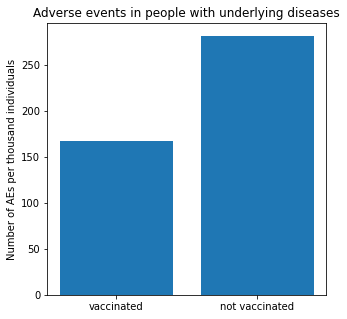

In [133]:
plt.figure(figsize = (5,5))
plt.bar(df_sum_ud.index, df_sum_ud['Number of AEs per thousand individuals'])
plt.ylabel('Number of AEs per thousand individuals')
plt.title('Adverse events in people with underlying diseases')

Chi-squared test

In [134]:
# contingency table
crosstab_ud = contingency(df_AEs_ud, id_ud_vac, id_ud_nvac, columns = ls_AE, index = dict_vacORnot)
crosstab_ud

,AE,no AE,Total
vaccinated,1,2,3.0
not vaccinated,136,1753,1889.0
Total,137,1755,1892.0


In [135]:
# define significance treshold
alpha = 0.05

# perform chi-squared test:
stat, p, dof, expected = sp.stats.chi2_contingency(crosstab_ud.iloc[0:2,0:2], 1)

p

0.5284113641317825

Calculate and plot risk ratio

In [136]:
RR_ud = riskratio(crosstab_ud)
RR_ud

RR           4.629902
CI_lower     0.926847
CI_upper    23.127864
dtype: float64

([], [])

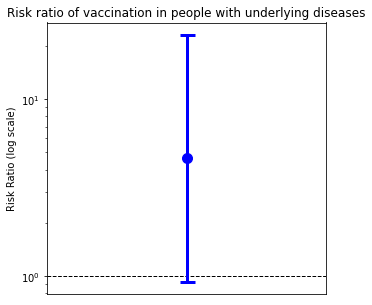

In [137]:
plt.figure(figsize = (5,5))
plt.yscale("log")
plt.axhline(1, ls='--', linewidth=1, color='black')
    
# draw the CI
x = [0,0] # x location at 0
y = [RR_ud['CI_lower'], RR_ud['CI_upper']]
plt.plot(x, y, "_-", markersize = 15, markeredgewidth= 3, linewidth = 3, color = 'b')

# draw the RR
x = [0]
y = [RR_ud['RR']]
plt.plot(x, y, "o", markersize = 10, color = 'b')

# labels
plt.xlabel('')
plt.ylabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in people with underlying diseases')
plt.xticks([]) # empty list gives no x-ticks

In [138]:
# create a df for collecting the results of the risk ratio to compare the populations

# initialize
RR_result = pd.DataFrame(index = ['whole population', 'people with underlying diseases'], columns = ['RR', 'CI_lower', 'CI_upper'])

# fill it
# RR with data from all individuals in the scripts & clinical dataset
RR_result.loc['whole population',:] = RR_all
# RR with data from all individuals with underlying diseases
RR_result.loc['people with underlying diseases',:] = RR_ud

RR_result

,RR,CI_lower,CI_upper
whole population,3.071596,0.509582,18.514608
people with underlying diseases,4.629902,0.926847,23.127864


In [139]:
loc = []
loc.append(3)
loc

[3]

(-0.5, 1.5)

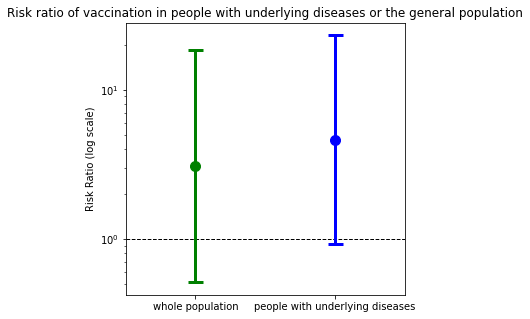

In [140]:
# plot the difference

# fig, ax = plt.subplots(figsize=(7, 5))
plt.figure(figsize = (5,5))
plt.yscale("log")
plt.axhline(1, ls='--', linewidth=1, color='black')

color = ['g','b']

# initialize counter
c = 0
# initialize location array for labelling x ticks
loc = []

# looping through the rows, i = index of row and res = data as a series
for i, res in RR_result.iterrows():
    
    # draw the CI
    x = [c,c] # x location
    y = [res['CI_lower'], res['CI_upper']]
    plt.plot(x, y, "_-", markersize = 15, markeredgewidth= 3, linewidth = 3, color = color[c])
    
    # draw the RR
    x = [c] # x location
    y = [res['RR']]
    plt.plot(x, y, "o", markersize = 10, color = color[c])
    
    # append the x location to the location list for labelling x ticks
    loc.append(c)
    c += 1

# labelling
plt.ylabel('Risk Ratio (log scale)')
plt.title('Risk ratio of vaccination in people with underlying diseases or the general population')
plt.xticks(ticks = loc, labels = RR_result.index)
plt.xlim(-0.5,1.5)

## 3. Are they more common in people with (specific) underlying medical conditions?

Incidence

In [141]:
# dictionary of disease categories to analyse, from https://www.icd10data.com/ICD10CM/Codes
dict_cat = {('A','B'):'Certain infectious and parasitic diseases',
           ('C','D0','D1','D2','D3','D4'):'Neoplasms',
           ('D5','D6','D7','D8'):'Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism',
           'E':'Endocrine, nutritional and metabolic diseases',
           'F':'Mental, Behavioral and Neurodevelopmental disorders',
           'G':'Diseases of the nervous system',
           ('H0','H1','H2','H3','H4','H5'):'Diseases of the eye and adnexa',
           ('H6','H7','H8', 'H9'): 'Diseases of the ear and mastoid process',
           'I':'Diseases of the circulatory system',
           'J':'Diseases of the respiratory system',
           'K':'Diseases of the digestive system',
           'L':'Diseases of the skin and subcutaneous tissue',
           'M':'Diseases of the musculoskeletal system and connective tissue',
           'N':'Diseases of the genitourinary system',
           'Q':'Congenital malformations, deformations and chromosomal abnormalities'}

# initialize dataframe for collecting values with/without vaccinated people for all categories
df_sum_cat_all = pd.DataFrame(columns = dict_vacORnot, index=dict_cat.values()) 

for i, ic in enumerate(dict_cat): # loop over ICD10 codes of each disease category
  
    # get dataset with only AEs AND people with specific underlying disease
    # subset of the df with all AEs (df_AEs) with only people with specific underlying diseases
    # reminder: leave R as adverse event & Q as underlying disease.
    # df_ud = subset of clinical_vac df with only diagnoses before vaccine as defined further above

    # subset with only underlying diseases within the specific category
    df_cat = df_ud[df_ud['icd10_code'].str.startswith(ic)]

    # IDs with underlying disease in the specific category
    id_cat = df_cat['eid'].unique()

    # subset of the df with AEs with only people with underlying disease in the specific category
    df_AEs_cat = df_AEs[df_AEs['eid'].isin(id_cat)]

    # get IDs of individuals in this subset with vs without vaccine 
    id_cat_vac = df_cat[df_cat['vaccinated']==True]['eid'].unique() # with vaccine
    id_cat_nvac = df_cat[df_cat['vaccinated']==False]['eid'].unique() # without vaccine

    df_sum_cat = incidence(df_AEs_cat, id_cat_vac, id_cat_nvac)
    
    # put in the values from the summary table
    df_sum_cat_all.loc[dict_cat[ic],:] = df_sum_cat.loc[:, 'Number of AEs per thousand individuals']
    
df_sum_cat_all.sort_values(by = 'vaccinated', ascending = False, inplace = True) # sorting
df_sum_cat_all

,vaccinated,not vaccinated
Neoplasms,500.0,468.451243
Diseases of the blood and blood-forming organs and certain disorders involving the immune mechanism,500.0,610.344828
"Endocrine, nutritional and metabolic diseases",500.0,589.74359
"Congenital malformations, deformations and chromosomal abnormalities",500.0,622.889306
"Mental, Behavioral and Neurodevelopmental disorders",250.0,490.335707
Diseases of the nervous system,250.0,593.663912
Diseases of the eye and adnexa,250.0,598.870056
Diseases of the ear and mastoid process,250.0,500.738552
Diseases of the circulatory system,250.0,581.620314
Diseases of the skin and subcutaneous tissue,250.0,498.917749


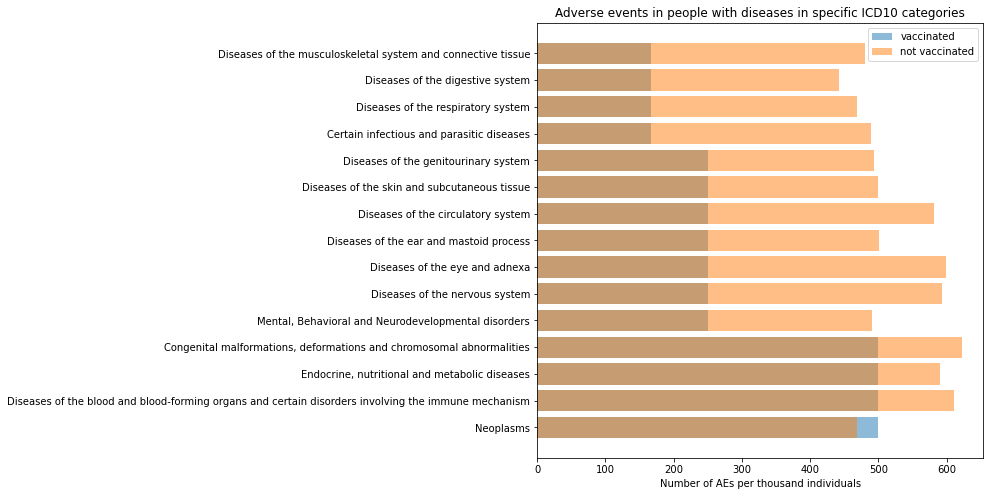

In [142]:
plt.figure(figsize = (8,8))

# plot results for vaccinated and not on top of each other
for v in dict_vacORnot:
    plt.barh(df_sum_cat_all.index, df_sum_cat_all[v], alpha = 0.5, label = v)

# labelling
plt.title('Adverse events in people with diseases in specific ICD10 categories')
plt.xlabel('Number of AEs per thousand individuals')
plt.legend(loc = "upper right")


Chi-squared test

Risk ratio

# Unused code so far

In [ ]:
# code layout for getting the different categories

# subsetting into categories using IC10
# e.g. I00-I99 Diseases of the circulatory system, more details available too, e.g. Ischemic heart diseases
GPic10.dropna(inplace=True) # drop NaN to enable making mask

m_circ = GPic10['icd10_code'].str.startswith('I')
GPic10[m_circ]['read_code']

In [ ]:
# getting corresponding CTV3 codes
m_circ_CTV3 = code['coding'].isin(GPic10[m_circ]['read_code'])
# code[m_circ_CTV3]

In [ ]:
 # getting subjects with this condition
m_circ_sub = clinical['code'].isin(code[m_circ_CTV3]['coding']) # another mask

# correspond to vaccinated or not

In [ ]:
# no one with any vaccine had circulatory issue before vaccine on this limited dataset
scripts[mask_vac]['eid'].isin(clinical[m_circ_sub]['eid']).sum()